<a href="https://colab.research.google.com/github/ppokranguser/Artificial_Intelligence_study/blob/main/240924_linear_regression_blanks%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression using PyTorch!

# Import Packages

In [1]:
# import packages here
from tqdm.notebook import tqdm

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Make the dataset! add noise to the linear function
- gt_w, gt_b : ground truth weight and bias for linear regression
- x : random points
- y : gt_w * x + gt_b + (gaussian) noise

In [2]:
### make the dataset here
gt_w = 4.0
gt_b = -2.0

num_data = 2000
noise_value = 2

x_range = np.array([-1,1])
x = np.linspace(x_range[0], x_range[1], num_data)

noise = noise_value * np.random.randn(num_data)
y_raw = gt_w * x + gt_b
y = gt_w * x + gt_b + noise

for x_i, y_i in zip(x, y_raw) :
    print(x_i, y_i)



-1.0 -6.0
-0.9989994997498749 -5.995997998999499
-0.9979989994997499 -5.991995997999
-0.9969984992496248 -5.987993996998499
-0.9959979989994997 -5.983991995997998
-0.9949974987493747 -5.979989994997499
-0.9939969984992496 -5.975987993996998
-0.9929964982491246 -5.9719859929964985
-0.9919959979989995 -5.9679839919959985
-0.9909954977488744 -5.963981990995498
-0.9899949974987494 -5.959979989994998
-0.9889944972486243 -5.955977988994498
-0.9879939969984992 -5.951975987993997
-0.9869934967483742 -5.947973986993497
-0.9859929964982491 -5.943971985992997
-0.984992496248124 -5.939969984992496
-0.983991995997999 -5.935967983991996
-0.9829914957478739 -5.931965982991496
-0.9819909954977488 -5.927963981990995
-0.9809904952476238 -5.923961980990495
-0.9799899949974987 -5.919959979989995
-0.9789894947473737 -5.9159579789894945
-0.9779889944972486 -5.9119559779889945
-0.9769884942471235 -5.907953976988495
-0.9759879939969985 -5.903951975987994
-0.9749874937468734 -5.899949974987494
-0.9739869934967

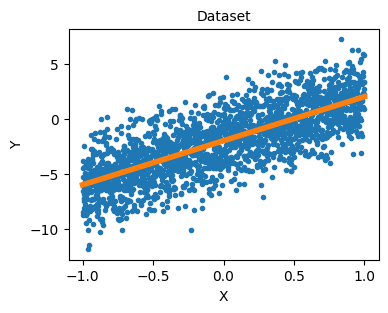

In [3]:
### Plot the dataset
plt.figure(figsize=(4,3))
plt.plot(x, y, '.')

plt.plot(x_range, x_range*gt_w+gt_b, linewidth=4)

plt.title('Dataset', fontsize=10)
plt.xlabel('X', fontsize=10)
plt.ylabel('Y', fontsize=10)
plt.show()


# Define the Pytorch Dataset with x y points
- Define your own class, which inherits from "Dataset" class of pytorch
- Define constructor of the class with `__init__`
- Define the length of the dataset with `__len__`
- Define the function when bringing out the idx-th dataset
    * Return the dictionary containing the input and output of single datapoint


In [4]:
# define the dataset here
class XY_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.num_data = x.shape[0]

        print('built new dataset!')

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample = dict()
        sample['x'] = self.x[idx]
        sample['y'] = self.y[idx]

        #print("sampled {}-th element.".format(idx))
        return sample


xy_dataset = XY_Dataset(x, y)

print(xy_dataset.__len__())
print(xy_dataset[5])
print(xy_dataset[125])
   ## TODO

built new dataset!
2000
{'x': -0.9949974987493747, 'y': -8.71047543942152}
{'x': -0.8749374687343672, 'y': -4.099905457037993}


# Define the dataset, and dataloader
- DataLoader makes you to randomly sample the dataset with a batch size you want.

In [5]:
### Define the batch size you want
batch_size = 8

### Create the instance of dataset, and dataloader
dataset = XY_Dataset(x,y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 0 1 2 3 4 5 ==> shuffle=True ==> 5 2 4 3 1 0 (Random shuffle)
# if batch size == 2
# (5, 2) (4, 3), (1, 0) batches will be returned from....
# for sample in dataloader:....
#     sample : (5,2), (4,3), (1,0)....

### Try sampling out one random data point.
sample = next(iter(dataloader))
print(sample)
print(sample['y'])
print(sample['x'].shape, sample['y'].shape)



built new dataset!
{'x': tensor([-0.3347,  0.9060, -0.0695, -0.8449,  0.1156, -0.0865,  0.2326, -0.5918],
       dtype=torch.float64), 'y': tensor([-4.1348, -1.7071, -2.7690, -4.5637,  0.6452,  0.3153, -3.4537, -4.6231],
       dtype=torch.float64)}
tensor([-4.1348, -1.7071, -2.7690, -4.5637,  0.6452,  0.3153, -3.4537, -4.6231],
       dtype=torch.float64)
torch.Size([8]) torch.Size([8])


# Initialize the weight and bias.

In [22]:
# initialize the weight and bias here
### Needs requires_grad=True, if you want to make as a parameter to train.
pred_w = torch.randn(1, requires_grad=True)
pred_b = torch.randn(1, requires_grad=True)
print('Initialized w: {}, b: {}'.format(pred_w.item(), pred_b.item()))
print(pred_w)
print(pred_b)


Initialized w: -0.1637009233236313, b: 1.1998755931854248
tensor([-0.1637], requires_grad=True)
tensor([1.1999], requires_grad=True)


# Define the ,,train'' function.

In [23]:
def train(pred_w, pred_b, sample, learning_rate):
    '''
    pred_w, pred_b : weight and biae to train.
    sample : sample from dataloader. dictionary containing 'x' and 'y'.
    learning_rate : the learning rate you want.
    '''

    # 1. get prediction
    pred_y = pred_w * sample['x'] + pred_b

    # 2. calculate the pred_loss
    criteria = nn.MSELoss()
    pred_loss = criteria(pred_y, sample['y']) # MSE loss 직접 계산

    # 3. make pytorch compute the gradient
    pred_loss.backward()

    # 4. need ''no grad'' to keep the computed gradient
    with torch.no_grad():
        pred_w -= learning_rate * pred_w.grad
        pred_b -= learning_rate * pred_b.grad

    # 5. initialize the gradient to zero
    pred_w.grad.zero_()
    pred_b.grad.zero_()

    return pred_loss

# Iterate over the dataset! With your ,,train'' function

In [24]:
# define the training process here
max_epoch = 100

loss_saver = list()

saved_w = []
saved_b = []

for epoch in tqdm(range(max_epoch)):

    total_loss = 0.0
    for idx, sample in enumerate(dataloader):
        pred_loss = train(pred_w, pred_b, sample, learning_rate=1e-2)
        total_loss += pred_loss.item()/len(dataloader)

    loss_saver.append(total_loss)

    if (epoch+1) % 10 == 0:
        saved_w.append(pred_w.item())
        saved_b.append(pred_b.item())
        print('Epoch: {}, Loss: {}, pred_w : {}, pred_b : {}'.format(epoch+1, total_loss, pred_w.item(), pred_b.item()))

print('Final Prediction : pred_w = {}, pred_b = {}'.format(pred_w.item(), pred_b.item()))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, Loss: 4.0420371746773744, pred_w : 3.984527587890625, pred_b : -2.0621728897094727
Epoch: 20, Loss: 4.04006124719407, pred_w : 4.033140182495117, pred_b : -2.0225398540496826
Epoch: 30, Loss: 4.035748748811944, pred_w : 3.9661545753479004, pred_b : -2.092456817626953
Epoch: 40, Loss: 4.032802266758249, pred_w : 3.9508018493652344, pred_b : -2.0963361263275146
Epoch: 50, Loss: 4.042316549020994, pred_w : 4.023988723754883, pred_b : -2.0194616317749023
Epoch: 60, Loss: 4.042686937352435, pred_w : 4.007688045501709, pred_b : -2.098383903503418
Epoch: 70, Loss: 4.043956185404363, pred_w : 4.017385005950928, pred_b : -2.0376076698303223
Epoch: 80, Loss: 4.039248337871029, pred_w : 3.995032548904419, pred_b : -2.1379482746124268
Epoch: 90, Loss: 4.04213283725722, pred_w : 4.047475814819336, pred_b : -2.041344404220581
Epoch: 100, Loss: 4.042344850294804, pred_w : 4.014391899108887, pred_b : -2.0486559867858887
Final Prediction : pred_w = 4.014391899108887, pred_b = -2.048655986785

# Plot the result : training loss and resulted linear regressor

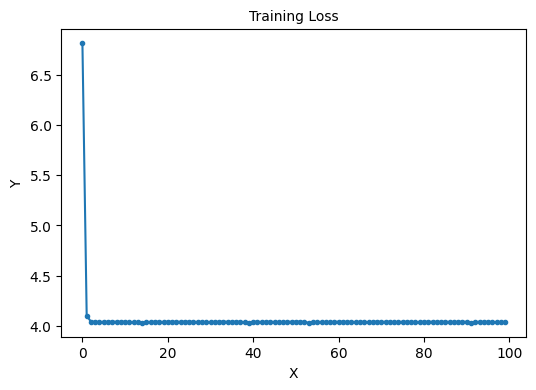

In [25]:
# plot the result: training loss
loss_saver = np.array(loss_saver)
plt.figure(figsize=(6,4))
plt.plot(np.arange(len(loss_saver)), loss_saver, '.-')
plt.title('Training Loss', fontsize=10)
plt.xlabel('X', fontsize=10)
plt.ylabel('Y', fontsize=10)
plt.show()

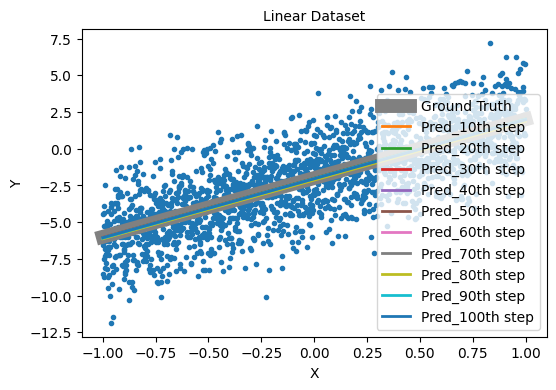

In [26]:
# plot the result: linear regressor
plt.figure(figsize = (6,4))

plt.plot(x,y, '.')

plt.plot(x_range, x_range*gt_w + gt_b, linewidth=10, color=[0.5,0.5,0.5], label = 'Ground Truth')

for idx, (w,b) in enumerate(zip(saved_w, saved_b)):
    plt.plot(x_range, x_range*w + b, linewidth=2, label='Pred_{}th step'.format(10*(idx+1)))

plt.title('Linear Dataset', fontsize=10)
plt.xlabel('X', fontsize=10)
plt.ylabel('Y', fontsize=10)
plt.legend()
plt.show()